In [1]:
from google.colab import drive
# mount to gdrive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



# model imports
from keras.applications.densenet import DenseNet201
from tensorflow.keras.callbacks import Callback
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision

# evaluation imports
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from shutil import rmtree
import os
from shutil import copyfile


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
data_dir = "/content/drive/My Drive/data/train"
#rmtree('train') # Remove existing, if re-run
#rmtree('test') # Remove existing, if re-run

os.makedirs('model-train/NORMAL', exist_ok=True)
os.makedirs('model-train/PNEUMONIA', exist_ok=True)
os.makedirs('model-test/NORMAL', exist_ok=True)
os.makedirs('model-test/PNEUMONIA', exist_ok=True)

# Split NORMAL
train, test = train_test_split(os.listdir(data_dir+'/NORMAL'), 
                               test_size=0.2, 
                               random_state=42)
for img in train:
    copyfile(os.path.join(data_dir+'/NORMAL', img), 
             os.path.join('model-train/NORMAL/', img))
for img in test:
    copyfile(os.path.join(data_dir+'/NORMAL', img), 
             os.path.join('model-test/NORMAL/', img))

# Split PNEUMONIA
train, test = train_test_split(os.listdir(data_dir+'/PNEUMONIA'), 
                               test_size=0.2, 
                               random_state=42)
for img in train:
    copyfile(os.path.join(data_dir+'/PNEUMONIA', img), 
             os.path.join('model-train/PNEUMONIA/', img))
for img in test:
    copyfile(os.path.join(data_dir+'/PNEUMONIA', img), 
             os.path.join('model-test/PNEUMONIA/', img))

In [5]:


SIZE = 128
BATCH = 64

# image augmentations
image_gen = ImageDataGenerator(rescale=1./255,
                                rotation_range=5,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                validation_split=0.2)

# flow_from_directory generators
train_generator = image_gen\
    .flow_from_directory('model-train',
                        target_size=(SIZE, SIZE),
                        class_mode="binary",
                        batch_size=BATCH,
                        subset='training')

validation_generator = image_gen\
    .flow_from_directory('model-train',
                        target_size=(SIZE, SIZE),
                        class_mode="binary",
                        batch_size=BATCH,
                        subset='validation')

Found 2884 images belonging to 2 classes.
Found 720 images belonging to 2 classes.


In [9]:


# Callbacks
## Keep the best model
mc = ModelCheckpoint('model.hdf5', 
                     save_best_only=True, 
                     verbose=0, 
                     monitor='val_loss', 
                     mode='min')

## Reduce learning rate if it gets stuck in a plateau
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.3, 
                        patience=3, 
                        min_lr=0.000001, 
                        verbose=1)

In [ ]:
# Create the DenseNet121 model
model = keras.applications.DenseNet201(include_top=False,
                                       input_shape=(SIZE, SIZE, 3),
                                       weights='imagenet')

# Freeze convolutional base
model.trainable = False

# Callbacks
## Keep the best model
mc = ModelCheckpoint('model.hdf5', 
                     save_best_only=True, 
                     verbose=0, 
                     monitor='val_loss', 
                     mode='min')

## Reduce learning rate if it gets stuck in a plateau
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.3, 
                        patience=3, 
                        min_lr=0.000001, 
                        verbose=1)

## Output layer
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

## Compile and run
model = Model(inputs=model.input, outputs=predictions)

model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model_history = model.fit(train_generator,
                            validation_data=validation_generator,
                            steps_per_epoch=train_generator.n/BATCH,
                            validation_steps=validation_generator.n/BATCH,
                            epochs=10,
                            verbose=1,
                              callbacks=[mc, rlr])

Epoch 1/10
52/52 [==============================] - 73s 1s/step - loss: 0.3012 - accuracy: 0.8668 - val_loss: 0.1560 - val_accuracy: 0.9294
Epoch 2/10
52/52 [==============================] - 67s 1s/step - loss: 0.1518 - accuracy: 0.9382 - val_loss: 0.1706 - val_accuracy: 0.9258
Epoch 3/10
52/52 [==============================] - 67s 1s/step - loss: 0.1369 - accuracy: 0.9471 - val_loss: 0.1163 - val_accuracy: 0.9557
Epoch 4/10
52/52 [==============================] - 68s 1s/step - loss: 0.1304 - accuracy: 0.9501 - val_loss: 0.1200 - val_accuracy: 0.9522
Epoch 5/10
52/52 [==============================] - 67s 1s/step - loss: 0.1146 - accuracy: 0.9531 - val_loss: 0.1079 - val_accuracy: 0.9569
Epoch 6/10
52/52 [==============================] - 66s 1s/step - loss: 0.1047 - accuracy: 0.9609 - val_loss: 0.1126 - val_accuracy: 0.9569
Epoch 7/10
52/52 [==============================] - 67s 1s/step - loss: 0.1068 - accuracy: 0.9576 - val_loss: 0.1022 - val_accuracy: 0.9593
Epoch 8/10
52/52 [==

In [ ]:

# Create the DenseNet121 model
model2 = keras.applications.DenseNet121(include_top=False,
                                       input_shape=(SIZE, SIZE, 3),
                                       weights='imagenet')

# Freeze convolutional base
model2.trainable = False

## Output layer
x = model2.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

## Compile and run
model2 = Model(inputs=model2.input, outputs=predictions)

model2.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model_history2 = model2.fit(train_generator,
                            validation_data=validation_generator,
                            steps_per_epoch=train_generator.n/BATCH,
                            validation_steps=validation_generator.n/BATCH,
                            epochs=10,
                            verbose=1,
                              callbacks=[mc, rlr])

Epoch 1/10
52/52 [==============================] - 73s 1s/step - loss: 0.2356 - accuracy: 0.8988 - val_loss: 0.1672 - val_accuracy: 0.9234 - lr: 0.0010
Epoch 2/10
52/52 [==============================] - 68s 1s/step - loss: 0.1544 - accuracy: 0.9367 - val_loss: 0.1194 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 3/10
52/52 [==============================] - 69s 1s/step - loss: 0.1333 - accuracy: 0.9468 - val_loss: 0.1523 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 4/10
52/52 [==============================] - 71s 1s/step - loss: 0.1113 - accuracy: 0.9603 - val_loss: 0.1141 - val_accuracy: 0.9545 - lr: 0.0010
Epoch 5/10
52/52 [==============================] - 71s 1s/step - loss: 0.1111 - accuracy: 0.9582 - val_loss: 0.1182 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 6/10
52/52 [==============================] - 71s 1s/step - loss: 0.1209 - accuracy: 0.9558 - val_loss: 0.1760 - val_accuracy: 0.9330 - lr: 0.0010
Epoch 7/10
53/52 [==============================] - ETA: 0s - loss: 0.1061 - accur

In [8]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

def create_model(frozen=1.0, hidden_layer=(64,32),activation = 'relu', optimizer='adam'): 
    model = keras.applications.DenseNet121(include_top=False,
                                           input_shape=(SIZE, SIZE, 3),
                                           weights='imagenet')  
    for layer in model.layers[:int(len(model.layers)*frozen)]:
        layer.trainable = False
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(hidden_layer[0], activation = activation)(x)
    x = Dense(hidden_layer[0], activation = activation)(x)
    predictions = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=model.input, outputs=predictions)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

In [ ]:
hyperparameter = dict(frozen=[1.0,0.5],
                      hidden_layer=[(1024,512),(64,32)],
                      activation = ['relu','sigmoid'],
                      optimizer=['adam','sgd'])

score_list = []
for frozen in hyperparameter["frozen"]:
    for hidden_layer in hyperparameter["hidden_layer"]:
        for activation in hyperparameter["activation"]:
            for optimizer in hyperparameter["optimizer"]:
                modeln = create_model(frozen=frozen,
                                     hidden_layer=hidden_layer,
                                     activation=activation,
                                     optimizer=optimizer)
                model_historyn = modeln.fit(train_generator,
                            validation_data=validation_generator,
                            steps_per_epoch=train_generator.n/BATCH,
                            validation_steps=validation_generator.n/BATCH,
                            epochs=3,
                            verbose=1,
                            callbacks=[mc, rlr])
                val_loss, val_accuracy = modeln.evaluate(validation_generator, verbose=0)
                score_list.append([val_loss,val_accuracy,frozen, hidden_layer,activation,optimizer,modeln])
score_list.sort(key = lambda x: x[1],reverse=True)
score_list[0][0:-1]

    

Epoch 1/3
52/52 [==============================] - 75s 1s/step - loss: 0.4108 - accuracy: 0.8791 - val_loss: 0.1451 - val_accuracy: 0.9498 - lr: 0.0010
Epoch 2/3
52/52 [==============================] - 71s 1s/step - loss: 0.1441 - accuracy: 0.9460 - val_loss: 0.1246 - val_accuracy: 0.9474 - lr: 0.0010
Epoch 3/3
52/52 [==============================] - 71s 1s/step - loss: 0.1196 - accuracy: 0.9522 - val_loss: 0.1826 - val_accuracy: 0.9270 - lr: 0.0010
Epoch 1/3
52/52 [==============================] - 76s 1s/step - loss: 0.3511 - accuracy: 0.8549 - val_loss: 0.2059 - val_accuracy: 0.9222 - lr: 0.0100
Epoch 2/3
52/52 [==============================] - 70s 1s/step - loss: 0.2048 - accuracy: 0.9185 - val_loss: 0.1901 - val_accuracy: 0.9187 - lr: 0.0100
Epoch 3/3
52/52 [==============================] - 70s 1s/step - loss: 0.1744 - accuracy: 0.9313 - val_loss: 0.1581 - val_accuracy: 0.9342 - lr: 0.0100
Epoch 1/3
52/52 [==============================] - 77s 1s/step - loss: 0.3162 - accuracy

[0.47717177867889404, 0.7428229451179504]

In [12]:
best_params = score_list[0][2:6]
final_model = create_model(frozen=best_params[0],
                            hidden_layer=best_params[1],
                            activation=best_params[2],
                            optimizer=best_params[3])
final_model_history = final_model.fit(train_generator,
                            validation_data=validation_generator,
                            steps_per_epoch=train_generator.n/BATCH,
                            validation_steps=validation_generator.n/BATCH,
                            epochs=10,
                            verbose=1,
                            callbacks=[mc, rlr])


Epoch 1/10
45/45 [==============================] - 253s 5s/step - loss: 0.2311 - accuracy: 0.8984 - val_loss: 0.1496 - val_accuracy: 0.9306 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - 275s 6s/step - loss: 0.1249 - accuracy: 0.9504 - val_loss: 0.1221 - val_accuracy: 0.9514 - lr: 0.0010
Epoch 3/10
45/45 [==============================] - 237s 5s/step - loss: 0.1055 - accuracy: 0.9577 - val_loss: 0.1099 - val_accuracy: 0.9597 - lr: 0.0010
Epoch 4/10
45/45 [==============================] - 271s 6s/step - loss: 0.0958 - accuracy: 0.9657 - val_loss: 0.1067 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 5/10
45/45 [==============================] - 271s 6s/step - loss: 0.1063 - accuracy: 0.9580 - val_loss: 0.0959 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 6/10
45/45 [==============================] - 272s 6s/step - loss: 0.0959 - accuracy: 0.9622 - val_loss: 0.1122 - val_accuracy: 0.9639 - lr: 0.0010
Epoch 7/10
45/45 [==============================] - 235s 5s/step - loss: 0.0

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the accuracy, precision, recall, and F1 score on the validation set
validation_generator.reset()
y_true = []
y_pred = []
for i in range(len(validation_generator)):
    x_val, y_val = validation_generator[i]
    y_pred_batch = final_model.predict(x_val)
    y_pred_batch = np.round(y_pred_batch)
    y_true.extend(y_val)
    y_pred.extend(y_pred_batch)
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1 Score:', f1)

1/1 [==============================] - 3s 3s/step
Accuracy: 0.9652777777777778
Precision: 0.9775641025641025
Recall: 0.9822866344605475
F1 Score: 0.9799196787148594


<Figure size 432x288 with 0 Axes>

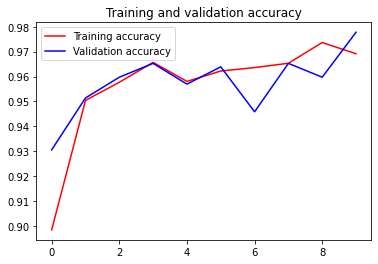

<Figure size 432x288 with 0 Axes>

In [14]:
# load the best model
final_model.load_weights("model.hdf5")
     

# plot training and validation accuracy by epoch
acc = final_model_history.history['accuracy']
val_acc = final_model_history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

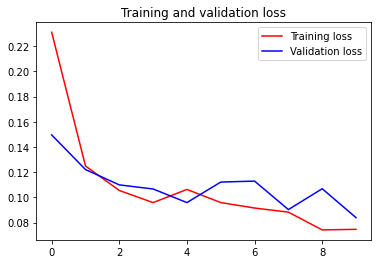

<Figure size 432x288 with 0 Axes>

In [17]:
# load the best model
final_model.load_weights("model.hdf5")
     

# plot training and validation accuracy by epoch
acc = final_model_history.history['loss']
val_acc = final_model_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training loss')
plt.plot(epochs, val_acc, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

Found 902 images belonging to 2 classes.


<ipython-input-16-3f5d023e9fc0>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = final_model.predict_generator(generator=test_generator) # get proba predictions


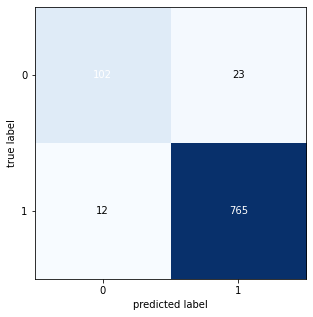

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=5,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)

test_generator = test_datagen.flow_from_directory(
    directory="model-test",
    target_size=(SIZE, SIZE),
    class_mode="binary",
    shuffle=False,
    batch_size=BATCH
)

preds = final_model.predict_generator(generator=test_generator) # get proba predictions
labels = 1*(preds > 0.5) # convert proba to classes
     

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
CM = confusion_matrix(test_generator.classes, labels)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()